## Q1.3 Multi-Layer Perceptrons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import shap
from scipy import stats
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
X_train = pd.read_csv('data/processed_data/X_train_processed.csv')
y_train = pd.read_csv('data/processed_data/y_train_processed.csv')['HeartDisease']
X_test = pd.read_csv('data/processed_data/X_test_processed.csv')
y_test = pd.read_csv('data/processed_data/y_test.csv')['HeartDisease']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Check feature names to understand the data
print("\n Features in the dataset:")
print(X_train.columns.tolist())
X_train.info()

Training data shape: (796, 15)
Testing data shape: (184, 15)

 Features in the dataset:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                796 non-null    float64
 1   RestingBP          796 non-null    float64
 2   Cholesterol        796 non-null    float64
 3   MaxHR              796 non-null    float64
 4   Oldpeak            796 non-null    float64
 5   Sex_M              796 non-null    float64
 6   ChestPainType_ATA  796 non-null    float64
 7   ChestPainType_NAP  796 non-null    float64
 8   ChestPainType_TA   796 non-null    float64
 9   FastingBS_1        796 non-null    float64

In [4]:
param_grid = {
    'hidden_layer_sizes': [(10,), (16,), (32,), (64,), (128,), (6,5), (12,8), (32, 16), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh', 'identity', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [4, 8, 16, 32, 64]
}
mlp_gs = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True)
grid_search = GridSearchCV(
    mlp_gs, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the best model on the full training set, make predictions
mlp_gs = grid_search.best_estimator_
mlp_gs.fit(X_train, y_train)
y_pred_gs = mlp_gs.predict(X_test)

# Evaluation
accuracy_gs = accuracy_score(y_test, y_pred_gs)
print(f"\nModel Performance (MLP with grid search):")
print(f"Accuracy: {accuracy_gs:.4f}")
print("\nClassification Report (MLP with grid search):")
print(classification_report(y_test, y_pred_gs))

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(10,), learning_rate=constant; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(16,), learning_rate=constant; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(32,), learning_rate=constant; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(64,), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(64,), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(128,), learning_rate=constant; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes=(6, 5), learning_rate=constant; total time=   1.7s
[CV] END activation=relu, alpha=0.0001, batch_size=4, hidden_layer_sizes

/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        74
           1       0.83      0.90      0.86       110

    accuracy                           0.83       184
   macro avg       0.83      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



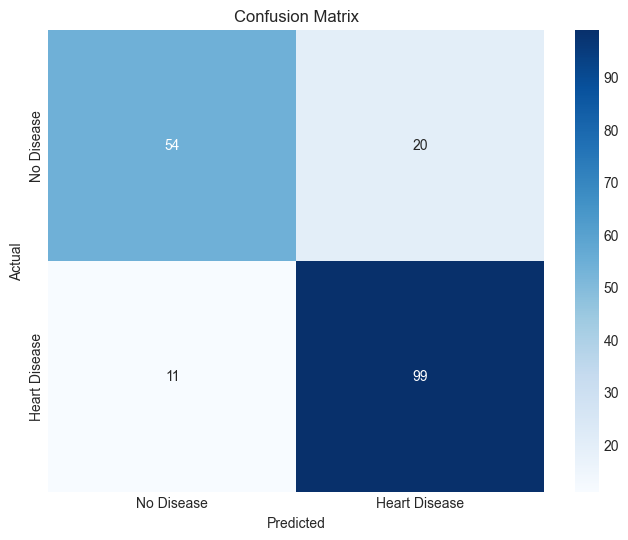

In [5]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

#Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Heart Disease'],
            yticklabels=['No Disease', 'Heart Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('data/mlp_confusion_matrix.png')
plt.show()

We proceed with SHAP to explain and visualize the model's predictions.

In [6]:
idx_11 = np.where((y_test == 1) & (y_pred == 1))[0] # true positive
idx_00 = np.where((y_test == 0) & (y_pred == 0))[0] # true negative
idx_10 = np.where((y_test == 1) & (y_pred == 0))[0] # false negative
idx_01 = np.where((y_test == 0) & (y_pred == 1))[0] # false positve

print("Indices where (y_test, y_pred) == (1,1):", idx_11)
print("Indices where (y_test, y_pred) == (0,0):", idx_00)
print("Indices where (y_test, y_pred) == (1,0):", idx_10)
print("Indices where (y_test, y_pred) == (0,1):", idx_01)

Indices where (y_test, y_pred) == (1,1): [  0   1   2   3   4   5   7   8   9  14  17  18  24  27  31  37  38  39
  40  41  42  43  46  47  50  51  52  56  57  58  66  68  69  70  71  72
  75  76  77  82  83  84  85  87  88  89  90  91  95  96 100 101 102 105
 107 108 109 110 114 118 119 121 122 123 127 130 132 134 135 136 137 138
 139 140 141 142 143 144 147 148 150 152 153 154 155 157 158 160 162 163
 164 165 168 169 170 175 177 178 182]
Indices where (y_test, y_pred) == (0,0): [  6  13  15  16  19  20  21  22  25  26  28  29  30  32  33  34  35  36
  48  54  55  63  65  73  74  78  79  80  93  94  97 104 112 113 115 116
 117 120 124 128 133 145 146 149 151 156 159 166 171 172 173 174 180 181]
Indices where (y_test, y_pred) == (1,0): [ 45  59  62  64  92  98  99 106 161 167 176]
Indices where (y_test, y_pred) == (0,1): [ 10  11  12  23  44  49  53  60  61  67  81  86 103 111 125 126 129 131
 179 183]


/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/1 [00:00<?, ?it/s]/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not

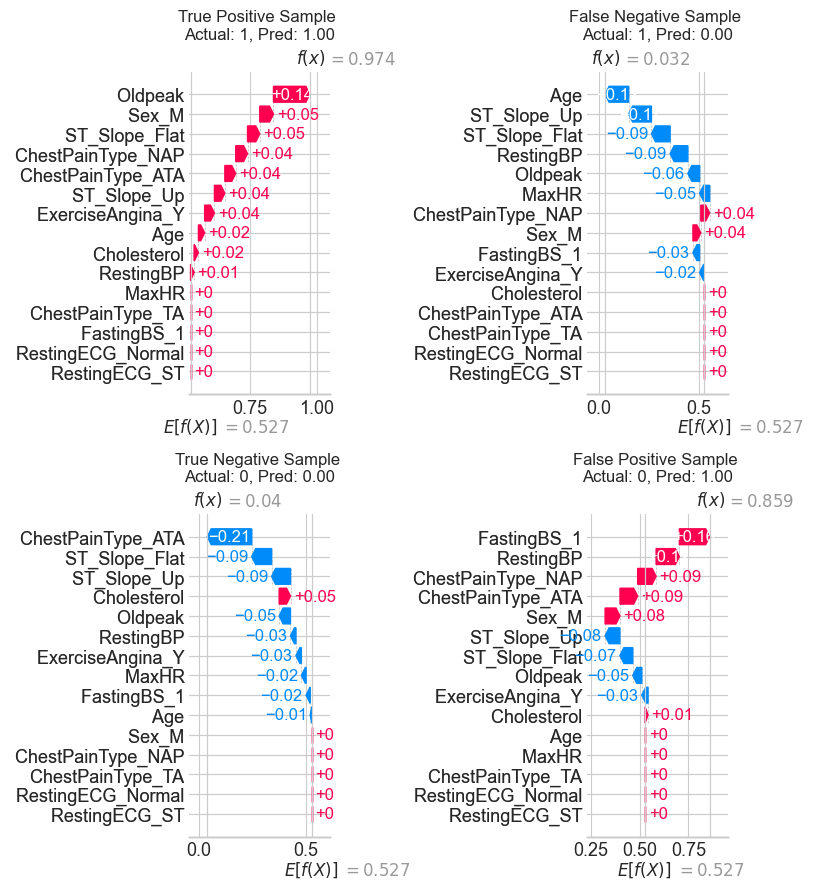

In [7]:
X_background = shap.utils.sample(X_train, 300)
explainer = shap.KernelExplainer(lambda x: mlp.predict_proba(x)[:, 1], X_background)

true_pos_ind = idx_11[0]
true_neg_ind = idx_00[0]
false_neg_ind = idx_10[0]
false_pos_ind = idx_01[0]

true_pos_sample = X_test.iloc[true_pos_ind:true_pos_ind+1]
true_neg_sample = X_test.iloc[true_neg_ind:true_neg_ind+1]
false_pos_sample = X_test.iloc[false_pos_ind:false_pos_ind+1]
false_neg_sample = X_test.iloc[false_neg_ind:false_neg_ind+1]

# Calculate SHAP values for these samples
shap_values_true_pos = explainer.shap_values(true_pos_sample)
shap_values_true_neg = explainer.shap_values(true_neg_sample)
shap_values_false_pos = explainer.shap_values(false_pos_sample)
shap_values_false_neg = explainer.shap_values(false_neg_sample)

# SHAP expected value
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0]
    
# Four subplots for the waterfall plots
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values_true_pos[0],
    X_test.iloc[true_pos_ind],
    feature_names=X_test.columns.tolist(),
    show=False,
    max_display=16
)
plt.title(f"True Positive Sample \nActual: {y_test.iloc[true_pos_ind]}, Pred: {y_pred[true_pos_ind]:.2f}")

plt.subplot(2, 2, 2)
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values_false_neg[0],
    X_test.iloc[false_neg_ind],
    feature_names=X_test.columns.tolist(),
    show=False,
    max_display=16
)
plt.title(f"False Negative Sample \nActual: {y_test.iloc[false_neg_ind]}, Pred: {y_pred[false_neg_ind]:.2f}")

plt.subplot(2, 2, 3)
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values_true_neg[0],
    X_test.iloc[true_neg_ind],
    feature_names=X_test.columns.tolist(),
    show=False,
    max_display=16
)
plt.title(f"True Negative Sample \nActual: {y_test.iloc[true_neg_ind]}, Pred: {y_pred[true_neg_ind]:.2f}")

plt.subplot(2, 2, 4)
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values_false_pos[0],
    X_test.iloc[false_pos_ind],
    feature_names=X_test.columns.tolist(),
    show=False,
    max_display=16
)
plt.title(f"False Positive Sample \nActual: {y_test.iloc[false_pos_ind]}, Pred: {y_pred[false_pos_ind]:.2f}")

plt.tight_layout()
plt.savefig('data/shap_4_waterfall_plots.png', bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/184 [00:00<?, ?it/s]/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  1%|          | 1/184 [00:00<00:48,  3.76it/s]/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  1%|          | 2/184 [00:00<00:46,  3.90it/s]/Users/melanier

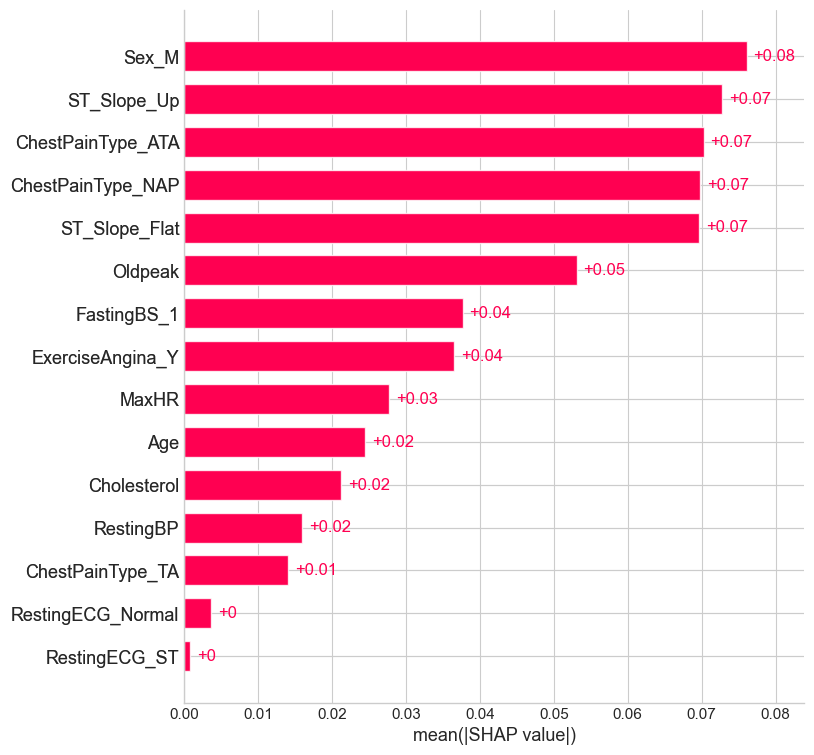

In [8]:
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=15, show=False)
plt.savefig('data/shap_global_features_barplot.png', bbox_inches='tight', dpi=300)
plt.show()

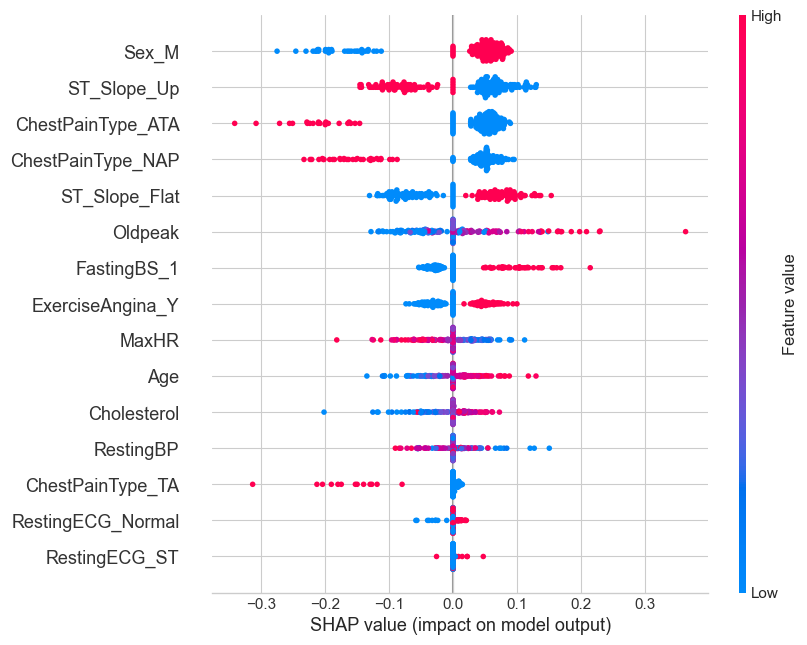

In [9]:
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.savefig('data/shap_beeswarm.png', bbox_inches='tight', dpi=300)
plt.show()

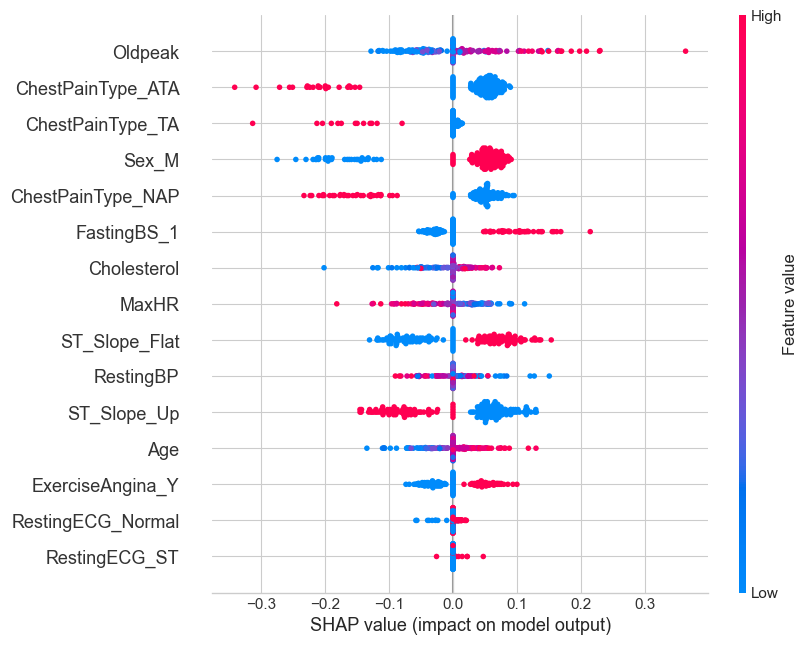

In [10]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display=15, show=False)
plt.savefig('data/shap_beeswarm_abs.png', bbox_inches='tight', dpi=300)
plt.show()